Checking GPU Specs and Consumption

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=da9d31ddaed47bff47bdbd7e0302e0b1f4c10765cacea271223f8e58bf13c8eb
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 157.8 MB
GPU RAM Free: 7611MB | Used: 0MB | Util   0% | Total 7611MB


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Defining The DataGenrator

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
        shear_range=0.0,
        zoom_range=0.0,
        horizontal_flip=False)
        
val_datagen = ImageDataGenerator(rescale = 1./255)

Data Generators

Found 474 images belonging to 1 classes.
Found 474 images belonging to 1 classes.
Found 135 images belonging to 1 classes.
Found 135 images belonging to 1 classes.


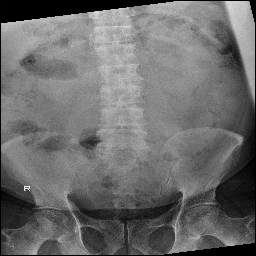

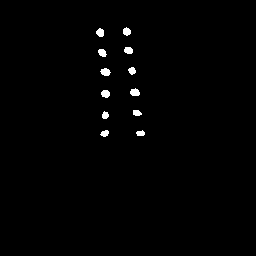

In [0]:
image_size = (256,256)
from google.colab.patches import cv2_imshow

train_image_generator = train_datagen.flow_from_directory(
'/content/drive/My Drive/ELL888/Data2/AP/train',
batch_size = 8, target_size = image_size, class_mode = None, shuffle = False) #NORMALLY 4/8/16/32)
#x_train = train_image_generator.next()

train_mask_generator = train_datagen.flow_from_directory(
'/content/drive/My Drive/ELL888/Data2/Ap_Pedicle/train',
batch_size = 8, target_size = image_size, color_mode = 'grayscale', class_mode = None, shuffle = False) #NORMALLY 4/8/16/32)
#y_train = train_image_generator.next()

val_image_generator = val_datagen.flow_from_directory(
'/content/drive/My Drive/ELL888/Data2/AP/val',
batch_size = 4, target_size = image_size, class_mode = None, shuffle = False) #NORMALLY 4/8/16/32)
#x_val = val_image_generator.next()

val_mask_generator = val_datagen.flow_from_directory(
'/content/drive/My Drive/ELL888/Data2/Ap_Pedicle/val',
batch_size = 4, target_size = image_size, color_mode = 'grayscale', class_mode = None, shuffle = False) #NORMALLY 4/8/16/32)
#y_val = val_image_generator.next()


train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

cv2_imshow(train_image_generator[0][1]*255)
cv2_imshow(train_mask_generator[0][1]*255)

Installing The Segmentation Models Library

In [0]:
!pip install -U segmentation-models

Requirement already up-to-date: segmentation-models in /usr/local/lib/python3.6/dist-packages (1.0.1)


Declaring The model

In [0]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import segmentation_models as sm

BACKBONE = 'efficientnetb3'

def seg_model(input_size = (256,256,3)):

  model = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape = input_size)
  model.compile(
      optimizer = Adam(1e-4),
      loss=sm.losses.bce_jaccard_loss,
      metrics=[sm.metrics.iou_score],
  )

  return model

Evaluating the Model

In [0]:
model = seg_model(input_size = (256,256,3))

results = model.fit_generator(
        train_generator,
        steps_per_epoch=474//8,
        epochs=40,
        validation_data=val_generator,
        validation_steps=135//4)

Epoch 1/40


KeyboardInterrupt: ignored

Saving model

In [0]:
model.save('/content/drive/My Drive/LAT_Vertebra.h5')

Create the Test Generator

Found 69 images belonging to 1 classes.
Found 69 images belonging to 1 classes.


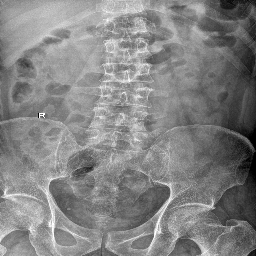

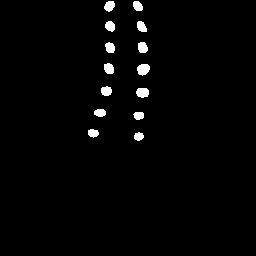

In [0]:
from google.colab.patches import cv2_imshow

test_image_generator = val_datagen.flow_from_directory(
'/content/drive/My Drive/ELL888/Data2/AP/test',
batch_size = 8, target_size = image_size, class_mode = None, shuffle = False) #NORMALLY 4/8/16/32)

test_mask_generator = val_datagen.flow_from_directory(
'/content/drive/My Drive/ELL888/Data2/Ap_Pedicle/test',
batch_size = 8, target_size = image_size, class_mode = None, color_mode = 'grayscale', shuffle = False) #NORMALLY 4/8/16/32)

test_generator = zip(test_image_generator, test_mask_generator)

cv2_imshow(test_image_generator[0][3]*255)
cv2_imshow(test_mask_generator[0][3]*255)

Loading the saved model

In [0]:
!pip install -U efficientnet

In [0]:
import efficientnet.tfkeras
from tensorflow.keras.models import load_model

In [0]:
from keras import backend as K

def swish_activation(x):
        return (K.sigmoid(x) * x)

get_custom_objects().update({'swish_activation': Activation(swish_activation)})


NameError: ignored

In [0]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/Copy of AP_Pedicle.h5', compile = False)

Evaluating on the test data

In [0]:
from keras.optimizers import Adam
import segmentation_models as sm

model.compile( optimizer = Adam(1e-4), loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)
test_generator = (pair for pair in zip(test_image_generator, test_mask_generator))

In [0]:
metrics = model.evaluate_generator(test_generator, steps=69//8, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

In [0]:
print(model.metrics_names)
print(metrics)

['loss', 'iou_score']
[0.4828438349068165, 0.5602424368262291]


Plotting the history

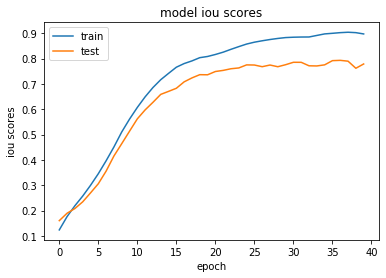

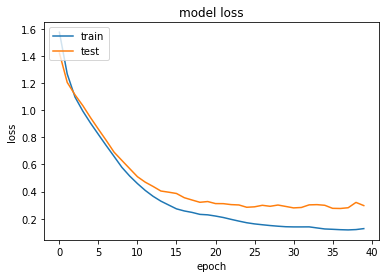

In [0]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(results.history['iou_score'])
plt.plot(results.history['val_iou_score'])
plt.title('model iou scores')
plt.ylabel('iou scores')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()